In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.preprocessing import RobustScaler

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from textwrap import fill

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)
import tensorflow_probability as tfp
warnings.filterwarnings('ignore')

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-12 21:02:43.034850: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 21:02:43.089253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 21:02:43.089302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 21:02:43.090907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to 

In [2]:
#Make Simulator and Training Data
cs_name_val = 10
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 5

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
print(simulator.noise_std)
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)
val_data = simulator.gen_sim_data(10, 10, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, seed + 1, False)
# print(sim_data.theta_vals)

0.024984087640608554


In [3]:
if method.emulator == True:
    all_gp_data = sim_data
    all_val_data = val_data
else:
    all_gp_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data, 1.0, False)
    print(len(all_gp_data.theta_vals), len(all_gp_data.x_vals), len(all_gp_data.y_vals))
    all_val_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, 1.0, False)
    print(len(all_val_data.theta_vals), len(all_val_data.x_vals), len(all_val_data.y_vals))

In [4]:
#Scale training data if necessary
scalerY = RobustScaler(unit_variance = True)
# scalerY = StandardScaler()
y = scalerY.fit_transform(sim_data.y_vals.reshape(-1,1))
y_test = scalerY.transform(val_data.y_vals.reshape(-1,1))
# y = sim_data.y_vals.reshape(-1,1)

In [5]:
#Test GPs
#Make CS Params
retrain_GP = 5
normalize = True
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel
print(noise_std)

#Make Emulator
#Evaluate GP Mean and Variance
# gp_object = Type_1_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
#                                 retrain_GP, seed, normalize, None, None, None, None)
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)
#Choose training data
train_data, test_data = gp_object.set_train_test_data(1.0, seed)
#Train GP
# gp_object.noise_std = None
gp_object.train_gp()
gpflow.utilities.print_summary(gp_object.fit_gp_model)
print(scalerY.scale_)
print(gp_object.fit_gp_model.kernel)

0.024984087640608554
╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤══════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                            │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪══════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 1.12228                          │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼──────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (7,)    │ float64 │ [2.97149, 3.76214, 0.88549142... │
├────────────────────────────────────┼───────────┼─────────────────

2024-03-12 21:03:04.532837: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤═════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                           │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪═════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 9.96957                         │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼─────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (7,)    │ float64 │ [20.73222, 5.15621, 44.08658... │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼────────────

2024-03-12 21:03:22.278974: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                              │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 2.316                              │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼────────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (7,)    │ float64 │ [0.63296322, 25.30571, 43.48481... │
├────────────────────────────────────┼───────────┼──────────────────┼───────

2024-03-12 21:06:31.703815: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤══════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                            │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪══════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 5.23444                          │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼──────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (7,)    │ float64 │ [31.16555, 40.11315, 65.49196... │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼──────

Text(0.5, 1.0, 'Histogram of CS10 Train')

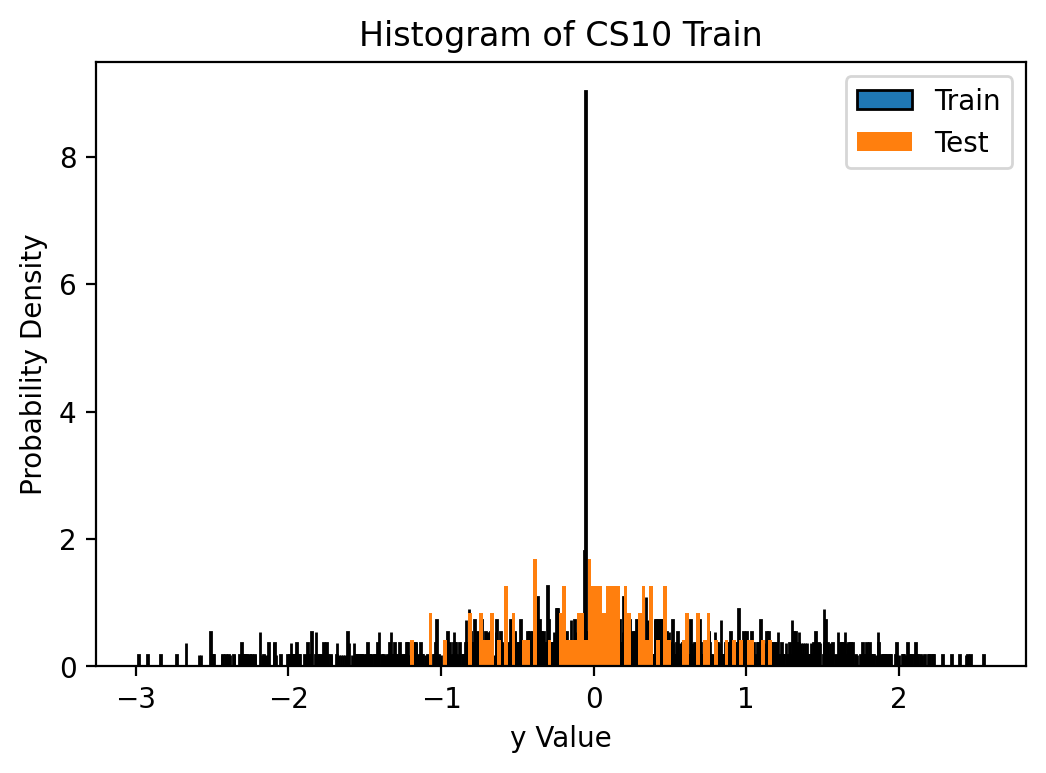

In [6]:
plt.hist(y, bins=int(len(y)), density=True, edgecolor = 'k', label = "Train") 
plt.hist(y_test, bins=int(len(y_test)), density=True, label = "Test") # Adjust the number of bins as needed
xmin, xmax = plt.xlim() 
mu, std = norm.fit(y[~np.isnan(y)])
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
# plt.plot(x, p, 'r', linewidth=2) 


# Add labels and title
plt.xlabel('y Value')
plt.legend(loc = "best")
plt.ylabel('Probability Density')
plt.title('Histogram of CS' + str(cs_name_val) + ' Train')

In [7]:
print(sum(y.flatten()**2)/len(y))

1.1222842634250036


In [8]:
print(gp_object.trained_hyperparams)
print(gp_object.trained_hyperparams[0].tolist() + gp_object.trained_hyperparams[1:] )

[array([31.16554559, 40.11315316, 65.49195955, 23.70458632, 21.86540277,
       49.7406521 , 92.67811001]), 1.7284280310588084e-06, 5.2344428886614365]
[31.165545588137526, 40.113153157032734, 65.49195954953696, 23.704586315953108, 21.86540277271842, 49.74065209749136, 92.67811000797059, 1.7284280310588084e-06, 5.2344428886614365]


In [9]:
# gp_object.fit_gp_model.kernel_.k1.k2.length_scale = np.array([4.45, 4.45, 0.684])
# gp_object.fit_gp_model.kernel_.k1.k1.constant_value = 0.997**2
# gp_object.fit_gp_model.kernel_.k2.noise_level = (0.0007680211296869702/1.1172376)**2
# 2.41**2 * Matern(length_scale=[3.78, 2.38, 1.2, 0.261, 1.14, 1.5], nu=2.5) + WhiteKernel(noise_level=8.08e-05)
print(gp_object.fit_gp_model.kernel)

In [10]:
#Evaluate GP Mean and Variance
# all_val_data = simulator.gen_sim_data(15, 15, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, simulator.seed, False)
feat_val = gp_object.featurize_data(all_val_data)
misc_gp_mean, misc_var_return = gp_object.eval_gp_mean_var_misc(all_val_data, feat_val, covar = False)
# misc_gp_mean, misc_var_return = gp_object.eval_gp_mean_var_val(covar = False)
# print(gp_object.scalerX.transform(np.concatenate((all_val_data.theta_vals, all_val_data.x_vals), axis = 1)))

In [11]:
# print(all_val_data.x_vals)
# print(misc_gp_mean)
# print(np.sqrt((misc_var_return)))

In [12]:
def kernel_info(kernel):
    outputscl_final = float(kernel.kernels[0].variance.numpy())
    lenscl_final = kernel.kernels[0].lengthscales.numpy()
    noise_final = float(kernel.kernels[1].variance.numpy())

    if isinstance(kernel.kernels[0], gpflow.kernels.RBF):
        kern_type = "RBF"
    elif isinstance(kernel.kernels[0], gpflow.kernels.Matern32):
        kern_type = "Mat32"
    elif isinstance(kernel.kernels[0], gpflow.kernels.Matern52):
        kern_type = "Mat52"
    else:
        print(type(kernel))

    if isinstance(lenscl_final, np.ndarray):
        lenscl_str = '[' + ', '.join('{:.2g}'.format(x) for x in lenscl_final) + ']'
    else:
        lenscl_str = f"{lenscl_final:.2g}"
    
    info_str = "tau=" +'{:.3g}'.format(outputscl_final) + ", "+ str(kern_type) +"="+ lenscl_str + ", noise="'{:.2g}'.format(noise_final)
    return info_str

print(kernel_info(gp_object.fit_gp_model.kernel))

tau=5.23, Mat52=[31, 40, 65, 24, 22, 50, 93], noise=1.7e-06


MSE: 84.59934219316676


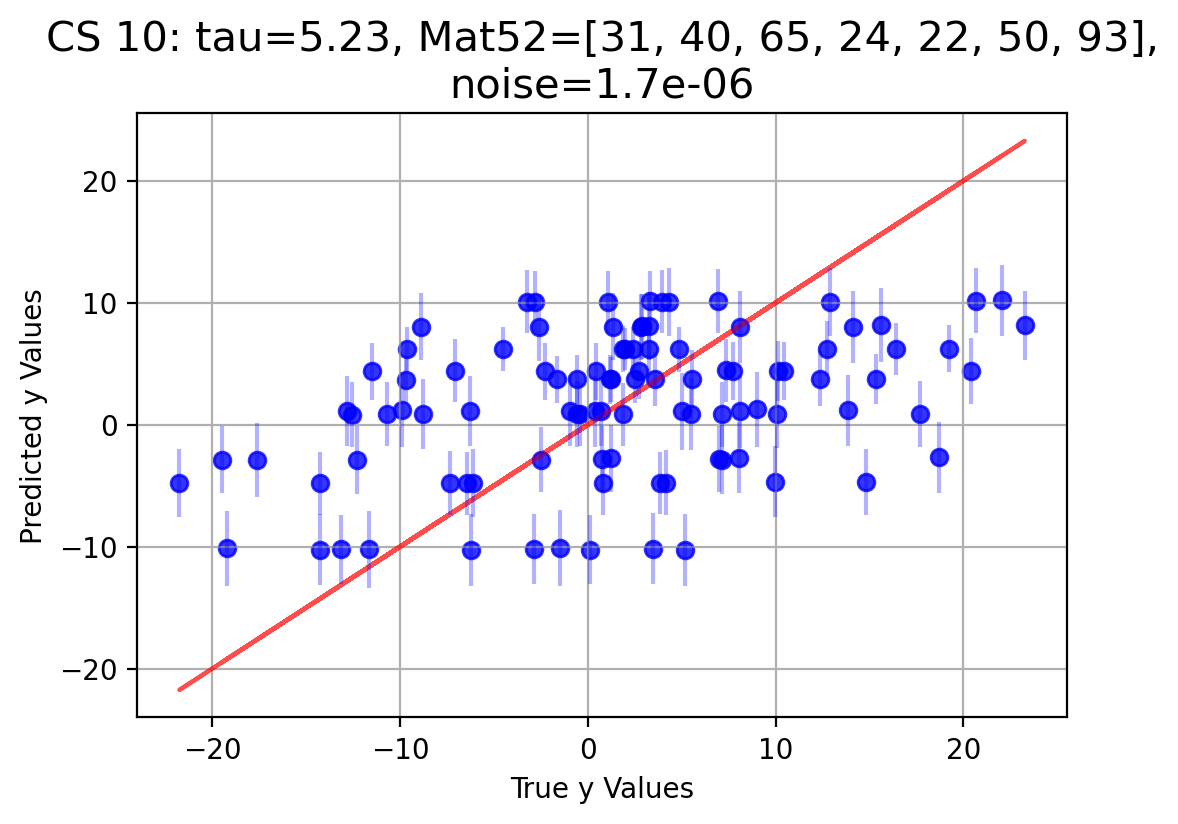

In [13]:
mse= np.sum((all_val_data.y_vals - misc_gp_mean)**2)/len(all_val_data.y_vals)
print("MSE:", mse)
plt.figure()
plt.plot(all_val_data.y_vals, all_val_data.y_vals, color='red', alpha=0.7)
plt.scatter(all_val_data.y_vals, misc_gp_mean, color='blue', alpha=0.7)
plt.errorbar(all_val_data.y_vals, misc_gp_mean, yerr = 1.96*np.sqrt(abs(misc_var_return)), alpha=0.3, fmt = 'o', color = "blue")
plt.xlabel('True y Values')
plt.ylabel('Predicted y Values')
# plt.xlim([0.95,1.2])
hp_list = gp_object.trained_hyperparams[0].tolist() + gp_object.trained_hyperparams[1:]
plt.title(fill("CS " + str(cs_name_val) + ": " + kernel_info(gp_object.fit_gp_model.kernel), 60), fontdict={'size':15})
plt.grid(True)
plt.show()